# Map Converter
This is a Jupyter Notebook to Convert a `.png` or `.pgm` + `.yaml` of a map into a `.csv` that can be fed into the TUMFTM functions.


Here is a high level overview of how this works:
1. We load the image and extract the left and right edges of the track
2. Associate inner lines with outer lines
3. Apply the right transformations

What is bad about this:
- The map cleaning is very tedious and manual, we should use `map_converter_v2` which uses a distance matrix instead. Or manually generate those centerline waypoints in simulation?
- 


We need to generate the following 4 columns:`x_m,y_m,w_tr_right_m,w_tr_left_m`

Maps supported:
- Black and white
- White and black

We can automatically detect what kind of map it is. 

Map Conditions:
- Map must be aligned somewhat in the center of the image (i.e. cannot just be in the top left, else algorithm will not find edges)
- Map should be closed and clean

You still need to manually check the map to make sure it is correct.
- Just check the starting positions, sometimes that doesn't work

In [140]:
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import yaml
import scipy
from scipy.ndimage import distance_transform_edt as edt
from PIL import Image
import os

In [155]:
# MAP_NAME = "Spielberg_map"
MAP_NAME = "e7_floor5"
FIXED_TRACK_WIDTH = True
TRACK_WIDTH_MARGIN = True # add a margin to the track width so it's more careful driving into the wall
INTERPOLATION_INTERVAL = 2
# INTERPOLATION_INTERVAL = 30  

In [156]:
# Modified from https://github.com/CL2-UWaterloo/Head-to-Head-Autonomous-Racing/blob/main/gym/f110_gym/envs/laser_models.py
# load map image

if os.path.exists(f"maps/{MAP_NAME}.png"):
    map_img_path = f"maps/{MAP_NAME}.png"
elif os.path.exists(f"maps/{MAP_NAME}.pgm"):
    map_img_path = f"maps/{MAP_NAME}.pgm"
else:
    raise Exception("Map not found!")

map_yaml_path = f"maps/{MAP_NAME}.yaml"
raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

# grayscale -> binary. Converts grey to black
map_img = raw_map_img.copy()
map_img[map_img <= 210.] = 0
map_img[map_img > 210.] = 1

map_height = map_img.shape[0]
# map_width = map_img.shape[1]
map_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

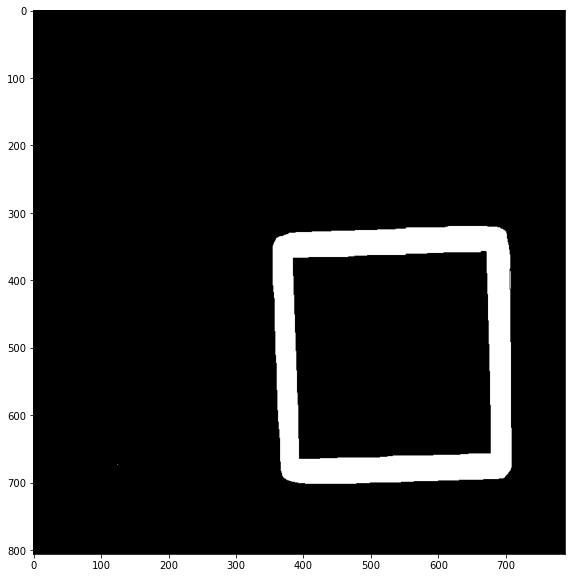

In [157]:
plt.figure(figsize=(10, 10))
plt.imshow(map_img, cmap='gray')

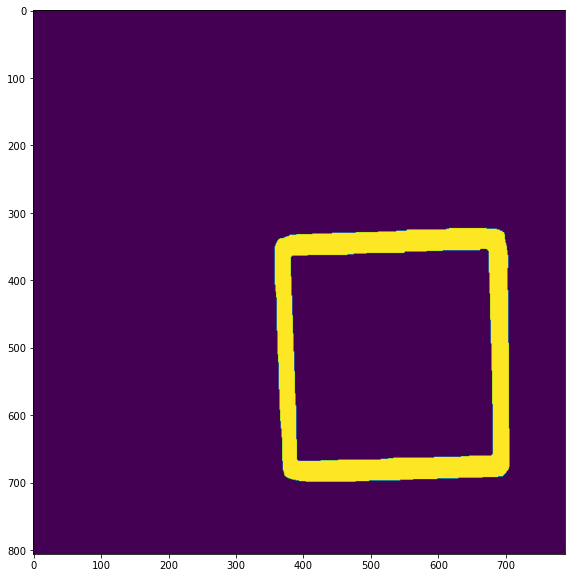

In [158]:
# Calculate Euclidean Distance Transform (tells us distance to nearest wall)
dist_transform = scipy.ndimage.distance_transform_edt(map_img)

# Threshold the distance transform to create a binary image
centers = dist_transform > 0.17*dist_transform.max()
plt.figure(figsize=(10, 10))
plt.imshow(centers)

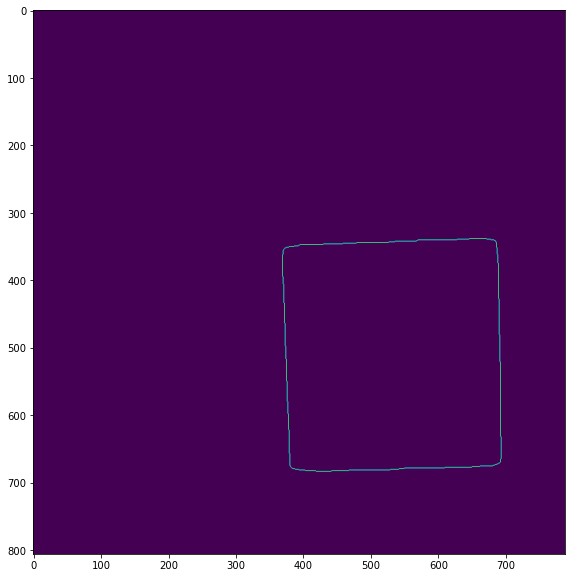

In [159]:
plt.figure(figsize=(10, 10))
centerline = skeletonize(centers)
plt.imshow(centerline)

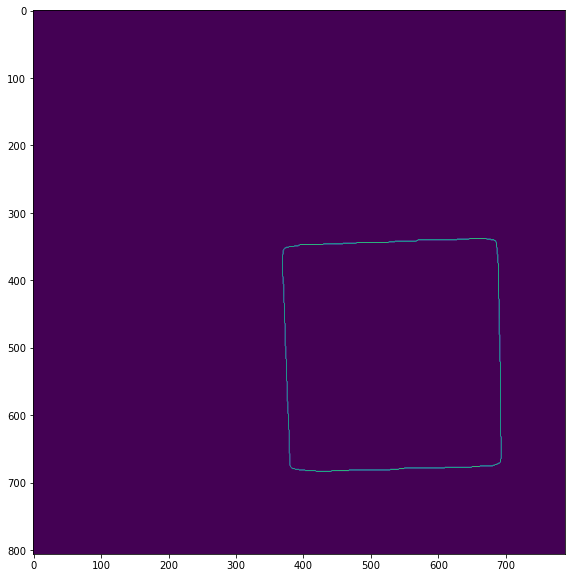

In [160]:
# The centerline has the track width encoded
plt.figure(figsize=(10, 10))
centerline_dist = np.where(centerline, dist_transform, 0)
plt.imshow(centerline_dist)

In [161]:
NON_EDGE = 0.0
print(f"Non-edge value: {NON_EDGE}")
# Use DFS to extract the outer edge
left_start_y = map_height // 2 - 10
left_start_x = 0
while (centerline_dist[left_start_y][left_start_x] == NON_EDGE): 
	left_start_x += 1

print(f"Starting position for left edge: {left_start_x} {left_start_y}")

Non-edge value: 0.0
Starting position for left edge: 369 393


In [162]:
# Run DFS
import sys
sys.setrecursionlimit(20000)

visited = {}
centerline_points = []
track_widths = []
DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

starting_point = (left_start_x, left_start_y)

def dfs(point):
	if (point in visited): return
	visited[point] = True
	centerline_points.append(np.array(point))
	track_widths.append(np.array([centerline_dist[point[1]][point[0]], centerline_dist[point[1]][point[0]]]))

	for direction in DIRECTIONS:
		if (centerline_dist[point[1] + direction[1]][point[0] + direction[0]] != NON_EDGE and (point[0] + direction[0], point[1] + direction[1]) not in visited):
			dfs((point[0] + direction[0], point[1] + direction[1]))

dfs(starting_point)

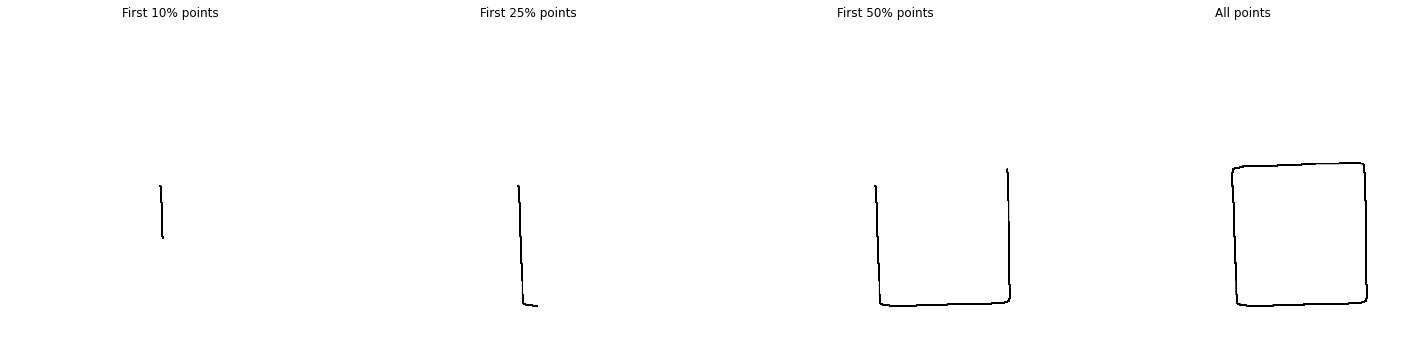

In [163]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points[:len(centerline_points)//10]:
	centerline_img[y][x] = 255
ax1.imshow(centerline_img, cmap='Greys', vmax=1)
ax1.set_title("First 10% points")

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points[:len(centerline_points)//4]:
	centerline_img[y][x] = 255
ax2.imshow(centerline_img, cmap='Greys', vmax=1)
ax2.set_title("First 25% points")

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points[:int(len(centerline_points)/1.4)]:
	centerline_img[y][x] = 255
ax3.imshow(centerline_img, cmap='Greys', vmax=1)
ax3.set_title("First 50% points")

centerline_img = np.zeros(map_img.shape)
for x,y in centerline_points:
	centerline_img[y][x] = 1000
ax4.imshow(centerline_img, cmap='Greys', vmax=1)
ax4.set_title("All points")
fig.tight_layout()

# Conversion
Convert into Pandas, and go from pixels to meters, and then shift by the origin.

In [164]:
track_widths

[array([15., 15.]),
 array([15., 15.]),
 array([15.13274595, 15.13274595]),
 array([15.29705854, 15.29705854]),
 array([15.5241747, 15.5241747]),
 array([15.8113883, 15.8113883]),
 array([16., 16.]),
 array([16., 16.]),
 array([16., 16.]),
 array([16., 16.]),
 array([15.8113883, 15.8113883]),
 array([15.5241747, 15.5241747]),
 array([15.29705854, 15.29705854]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([15., 15.]),
 array([14.86606875, 14.86606875]),
 array([14.56021978, 14.56021978]),
 array([14.31782106, 14.31782106]),
 array([14.14213562, 14.14213562]),
 array([14.03566885, 14.03566885]),
 array([14., 14.]),
 array([14., 14.]),
 array([14., 14.]),
 array([14., 14.]),
 array([14., 14.]),
 array([14., 14.]),
 array([14., 14.

In [165]:
track_widths_np = np.array(track_widths)
waypoints = np.array(centerline_points)
print(f"Track widths shape: {track_widths_np.shape}, waypoints shape: {waypoints.shape}")

Track widths shape: (1274, 2), waypoints shape: (1274, 2)


In [166]:
# Merge track with waypoints
data = np.concatenate((waypoints, track_widths_np), axis=1)
data.shape

(1274, 4)

In [167]:
# load map yaml
with open(map_yaml_path, 'r') as yaml_stream:
    try:
        map_metadata = yaml.safe_load(yaml_stream)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as ex:
        print(ex)

# calculate map parameters
orig_x = origin[0]
orig_y = origin[1]
# ??? Should be 0
orig_s = np.sin(origin[2])
orig_c = np.cos(origin[2])

# get the distance transform
transformed_data = data
transformed_data *= map_resolution
transformed_data += np.array([orig_x, orig_y, 0, 0])

if TRACK_WIDTH_MARGIN: # add extra safety margin
    transformed_data -= np.array([0, 0, 0.1, 0.1])

In [154]:
with open(f"inputs/tracks/{MAP_NAME}.csv", 'wb') as fh:
    np.savetxt(fh, transformed_data, fmt='%0.4f', delimiter=',', header='x_m,y_m,w_tr_right_m,w_tr_left_m')

Next up, check out `sanity_check.ipynb` to make sure that the centerline generated lines up with the map.